# Independent Multiple Time Series Forecasting: 

Forecast multiple time series with a single model, but each time series remains independent of the others, meaning that past values of one series are not used as predictors of other series. However, modeling them together is useful because the series may follow the same intrinsic pattern regarding their past and future values.

This will be used for several reasons:
- Baseline model
- What can we expect?
- Is it useful to use more sophisticated models? (Seq2Seq Deep Learning models) are they better?

Multi-series forecasts do not always outperform single-series forecasts. Which one works best depends largely on the characteristics of the use case to which they are applied.

#### Advantages of multi-series
- It is easier to maintain and monitor a single model than several.
- Since all time series are combined during training, the model has a higher learning capacity even if the series are short.
- By combining multiple time series, the model can learn more generalizable patterns.

#### Disadvantages of multi-series
- If the series do not follow the same internal dynamics, the model may learn a pattern that does not represent any of them.
- The series may mask each other, so the model may not predict all of them with the same performance.
- It is more computationally demanding (time and resources) to train and backtest a big model than several small ones.

#### Why LightGBM?
Tree-based algorithm, fast, efficient, scalable. One of the best models for time series forecasting. As the other GB algorithms, it builds a series of decision trees iteratively. Each tree tries to correct the mistakes made by the previous ones. Trees are built minimizing the loss function by adding weak learners in a sequential manner, where each subsequent tree learns from the residuals of the ensemble of trees built so far.

Unlike traditional depth-wise tree growth, LightGBM uses a leaf-wise growth strategy. Instead of growing the tree level by level (breadth-wise), LightGBM chooses the leaf with the maximum delta loss to grow. This results in a more balanced tree and reduces the number of levels in the tree, which contributes to faster training times.

LigthGBM also uses 2 other techniques that make this algorithm really effective: GOSS and EFB.
- **Gradient-based One-Side Sampling** (GOSS) to reduce the number of data instances used for training each tree. GOSS keeps the instances with large gradients (which contribute more to the learning process) and randomly samples the instances with small gradients. This allows for faster training without sacrificing much in terms of model performance.
- **Exclusive Feature Bundling** (EFB) to further improve efficiency. EFB groups exclusive features together during training, allowing for reduced memory usage and faster computation.

#### What we will do...
We will employ a simple, straight-forward, random, not-tuned, with no exogenous variables nor feature engineered LightGBM first on individual stocks and then a global model on the whole dataset (independent forecasting) and we will compare them. We will then perform preselection according to the predictions and check the performance of the portfolios.

## Importing Libraries

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import quantstats as qs
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# one of the best models for time series forecasting, as research and production deployments examples demonstrate
from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries        # global
from skforecast.ForecasterAutoreg import ForecasterAutoreg      # local
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [78]:
np.random.seed(2024)

## Load data

In [79]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')
index = pd.read_pickle('data/index_returns.pkl')

In [80]:
# create test set of returns for the benchmark (SX5E index)
test_index_ret = index.loc['2017-01-02':]

In [81]:
data = tukey.reset_index().rename(columns={'index':'Date'}).set_index('Date')
data.head(8)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
2013-01-09,150.639015,15.827395,71.009542,45.323106,19.125098,1.405432,73.282788,126.031903,3.195986,13.749587,...,104.897190,7.447657,48.849551,61.011026,7.526238,18.937751,12.583433,30.564229,66.302363,8.861539
2013-01-10,149.452580,15.727265,70.822367,45.607353,19.161744,1.428110,73.181097,124.892381,3.190310,13.623088,...,104.390636,7.557309,48.616030,60.806893,7.616594,18.997714,12.550908,31.038729,65.602069,8.973196
2013-01-11,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-14,149.933382,15.487656,71.344228,45.629157,19.635128,1.473812,73.101598,123.811027,3.212000,13.681092,...,104.542030,7.710230,48.700000,61.015621,7.751773,19.216099,12.548296,31.527151,65.151129,9.082648
2013-01-15,151.252415,15.418798,71.295815,45.688668,19.628250,1.485061,72.674043,123.981557,3.232909,13.658883,...,104.692494,7.706911,48.428008,60.776038,7.762634,19.263300,12.466558,31.531555,65.562005,9.037267
2013-01-16,151.454902,15.342877,71.552748,44.982329,19.627959,1.481329,72.442307,124.871308,3.231103,13.625171,...,105.361890,7.731382,48.145124,60.026067,7.744269,19.316224,12.347364,31.409631,66.192436,8.996555


In [82]:
data.shape

(1269, 41)

We need to fill up the series with the missing days since this type of model works only if the series is full, so basically if there are not any jumps between days

In [83]:
# adding saturdays and sundays and filling those NAs with a forward fill (fill them with the price of fridays)
data = data.asfreq('D').ffill()
data.head(8)

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-07,153.939608,15.863052,70.854575,44.436658,19.238627,1.380126,72.813778,127.405070,3.231326,13.850115,...,105.634999,7.310501,49.852665,61.648194,7.369072,18.959361,12.610719,29.582595,67.114440,8.771007
2013-01-08,152.295129,15.864724,70.827743,44.922120,19.152028,1.390526,73.053974,126.747672,3.202159,13.846611,...,104.938642,7.356010,49.264694,61.258046,7.436251,18.885706,12.580650,30.070623,66.745362,8.812163
2013-01-09,150.639015,15.827395,71.009542,45.323106,19.125098,1.405432,73.282788,126.031903,3.195986,13.749587,...,104.897190,7.447657,48.849551,61.011026,7.526238,18.937751,12.583433,30.564229,66.302363,8.861539
2013-01-10,149.452580,15.727265,70.822367,45.607353,19.161744,1.428110,73.181097,124.892381,3.190310,13.623088,...,104.390636,7.557309,48.616030,60.806893,7.616594,18.997714,12.550908,31.038729,65.602069,8.973196
2013-01-11,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-12,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-13,149.469007,15.647943,71.089809,45.684501,19.391704,1.453998,73.397973,124.341556,3.210371,13.641131,...,104.406391,7.695797,48.659719,60.888182,7.680333,19.172979,12.552136,31.371286,65.322242,9.052104
2013-01-14,149.933382,15.487656,71.344228,45.629157,19.635128,1.473812,73.101598,123.811027,3.212000,13.681092,...,104.542030,7.710230,48.700000,61.015621,7.751773,19.216099,12.548296,31.527151,65.151129,9.082648


In [84]:
data.shape

(1818, 41)

## Data Splitting

In [85]:
end_train = '2017-01-02'

In [86]:
data_train, data_test = data.loc[:end_train, :], data.loc[end_train:, :]

In [87]:
data_train.shape, data_test.shape

((1457, 41), (362, 41))

## Individual forecaster for each Stock

Here we built a **Forecast Autoregressor** object that instanciate a LightGBM model that will be fitted every time on a different time series. This approach will surely be more time consuming, but for the sake of the project we tried also this approach.

In [88]:
# Train and backtest a model for each stock: ForecasterAutoreg
items = []
mae_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):

    # Define forecaster
    forecaster = ForecasterAutoreg(
                     regressor     = LGBMRegressor(random_state=1),
                     lags          = 21,
                     transformer_y = MinMaxScaler()
                 )

    # Backtesting forecaster
    metric, preds = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data[item],
                        initial_train_size = len(data_train),
                        steps              = 7,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        fixed_train_size   = False,
                        verbose            = False,
                        show_progress      = False
                    )

    items.append(item)
    mae_values.append(metric)
    predictions[item] = preds

# Results
uni_series_mae = pd.Series(
                     data  = mae_values,
                     index = items,
                     name  = 'uni_series_mae'
                 )

100%|██████████| 41/41 [00:09<00:00,  4.26it/s]


## Multiseries forecaster

As we said before, after trying with an individual forecaster on each stock we decided to try to fit a "global" model that works passing as input the entire dataframe  with the series. The function **ForecasterAutoregMultiSeries** always creates an instance of a LightGBM model.

The function, **backtesting_forecaster_multiseries**, is designed for evaluating the performance of a forecaster model (such as autoregressive models for time series forecasting) using a backtesting approach. Backtesting is a technique commonly used in forecasting to assess how well a model would have performed on historical data. This function is specifically tailored for multi-series and multivariate forecasters, meaning it can handle cases where you have multiple time series or multiple predictors.

In [89]:
# Train and backtest a model for all stocks: ForecasterAutoregMultiSeries
items = list(data.columns)

forecaster_ms = ForecasterAutoregMultiSeries(
                    regressor          = LGBMRegressor(random_state=1),
                    lags               = 21,
                    transformer_series = MinMaxScaler(),
                )

multi_series_mae, predictions_ms = backtesting_forecaster_multiseries(
                                       forecaster         = forecaster_ms,
                                       series             = data,
                                       levels             = items,
                                       steps              = 7,
                                       metric             = 'mean_absolute_error',
                                       initial_train_size = len(data_train),
                                       refit              = False,
                                       fixed_train_size   = False,
                                       verbose            = False,
                                       show_progress      = True )

# Results
display(multi_series_mae.head(3))
print('')
display(predictions_ms.head(3))

  0%|          | 0/52 [00:00<?, ?it/s]

,levels,mean_absolute_error
0,VOW3 GY Equity,2.058437
1,ENGI FP Equity,0.198844
2,BAYN GY Equity,1.235651


,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2017-01-03,116.078270,12.149036,97.613393,60.259014,27.171789,2.429257,76.471539,180.156362,4.170838,23.947413,...,173.223008,6.407094,106.101432,82.36307,13.407948,15.491372,6.681785,15.552073,100.545171,16.320893
2017-01-04,116.034932,12.197236,97.859439,60.066506,27.148469,2.429257,76.520065,179.054394,4.169493,23.947413,...,173.096213,6.407720,105.199258,81.88236,13.372254,15.510778,6.679838,15.573867,100.799899,16.314927
2017-01-05,116.114633,12.189456,98.064503,59.958293,27.042820,2.429257,76.632124,178.331464,4.169493,23.947413,...,173.096213,6.407720,104.419691,81.63571,13.352549,15.544330,6.679838,15.561257,100.955174,16.314927


## Comparison: Single vs Multiple time series forecaster

In [90]:
multi_series_mae = multi_series_mae.set_index('levels')
multi_series_mae.columns = ['multi_series_mae']
results = pd.concat((uni_series_mae, multi_series_mae), axis = 1)
results['improvement'] = results.eval('uni_series_mae - multi_series_mae')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mae - multi_series_mae) / uni_series_mae')
results = results.round(2)
results.style.bar(subset=['improvement_(%)'], align='mid', color=['red', 'green'])

,uni_series_mae,multi_series_mae,improvement,improvement_(%)
VOW3 GY Equity,3.310000,2.060000,1.260000,37.900000
ENGI FP Equity,0.300000,0.200000,0.110000,34.690000
BAYN GY Equity,1.840000,1.240000,0.610000,32.870000
BNP FP Equity,3.410000,3.620000,-0.210000,-6.250000
PHIA NA Equity,2.720000,2.860000,-0.150000,-5.370000
ISP IM Equity,0.060000,0.040000,0.020000,31.110000
SAN FP Equity,1.220000,0.920000,0.300000,24.930000
MC FP Equity,40.360000,42.420000,-2.060000,-5.100000
ENEL IM Equity,0.490000,0.480000,0.000000,0.860000
CS FP Equity,0.310000,0.290000,0.020000,6.850000


In [91]:
results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max'])

,improvement,improvement_(%)
mean,0.077317,17.639024
min,-2.060000,-23.140000
max,1.260000,70.240000


In [92]:
# Number of series with positive and negative improvement
pd.Series(np.where(results['improvement_(%)'] < 0, 'negative', 'positive')).value_counts()

positive    32
negative     9
dtype: int64

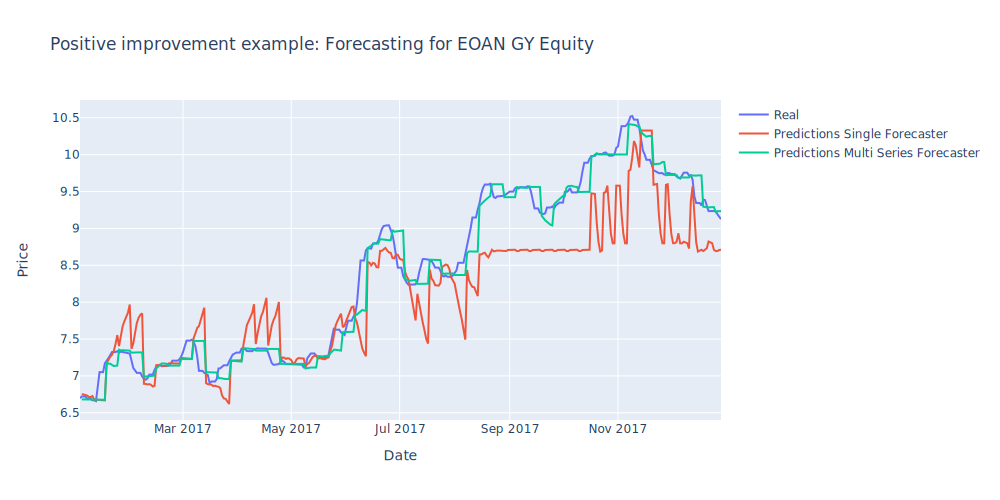

In [93]:
traces = []
traces.append(go.Scatter(x=data_test.index, y=data_test['EOAN GY Equity'], name='Real', mode='lines'))
traces.append(go.Scatter(x=predictions['EOAN GY Equity'].index, y=predictions['EOAN GY Equity']['pred'], name='Predictions Single Forecaster', mode='lines'))
traces.append(go.Scatter(x=predictions_ms['EOAN GY Equity'].index, y=predictions_ms['EOAN GY Equity'], name='Predictions Multi Series Forecaster', mode='lines'))

layout = go.Layout(title='Positive improvement example: Forecasting for EOAN GY Equity', xaxis=dict(title='Date'), yaxis=dict(title='Price'), width=1000)
fig = go.Figure(data=traces, layout=layout)
fig.show(renderer='svg')

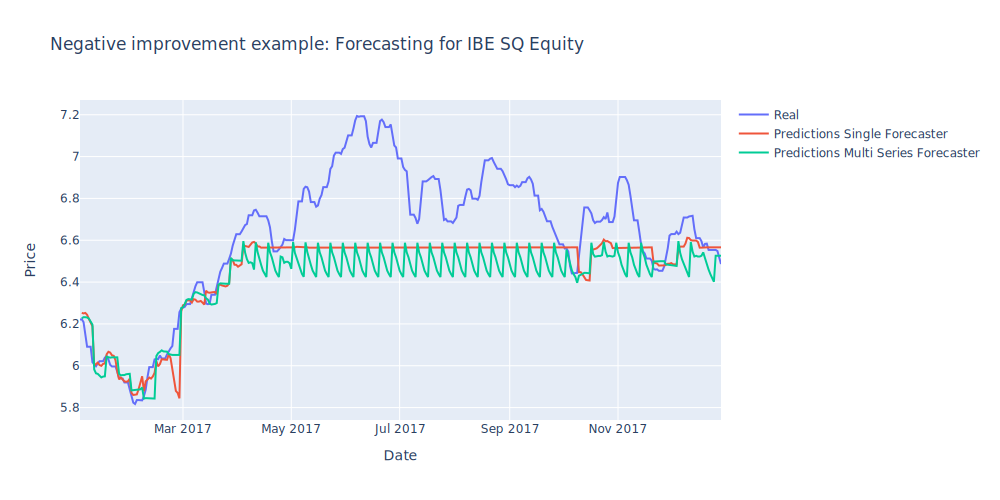

In [94]:
traces = []
traces.append(go.Scatter(x=data_test.index, y=data_test['IBE SQ Equity'], name='Real', mode='lines'))
traces.append(go.Scatter(x=predictions['EOAN GY Equity'].index, y=predictions['IBE SQ Equity']['pred'], name='Predictions Single Forecaster', mode='lines'))
traces.append(go.Scatter(x=predictions_ms['EOAN GY Equity'].index, y=predictions_ms['IBE SQ Equity'], name='Predictions Multi Series Forecaster', mode='lines'))

layout = go.Layout(title='Negative improvement example: Forecasting for IBE SQ Equity', xaxis=dict(title='Date'), yaxis=dict(title='Price'), width=1000)
fig = go.Figure(data=traces, layout=layout)
fig.show(renderer='svg')

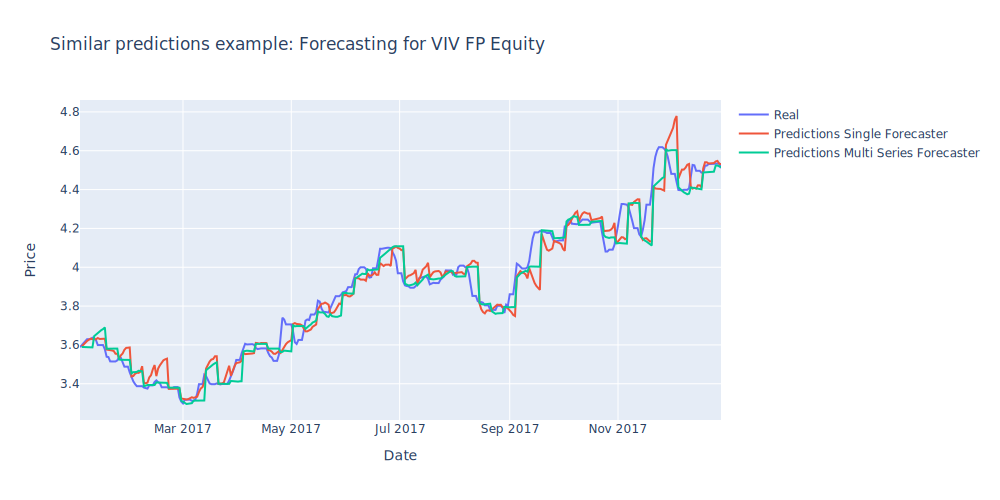

In [95]:
traces = []
traces.append(go.Scatter(x=data_test.index, y=data_test['VIV FP Equity'], name='Real', mode='lines'))
traces.append(go.Scatter(x=predictions['EOAN GY Equity'].index, y=predictions['VIV FP Equity']['pred'], name='Predictions Single Forecaster', mode='lines'))
traces.append(go.Scatter(x=predictions_ms['EOAN GY Equity'].index, y=predictions_ms['VIV FP Equity'], name='Predictions Multi Series Forecaster', mode='lines'))

layout = go.Layout(title='Similar predictions example: Forecasting for VIV FP Equity', xaxis=dict(title='Date'), yaxis=dict(title='Price'), width=1000)
fig = go.Figure(data=traces, layout=layout)
fig.show(renderer='svg')

Looks like that using a multi time series forecaster is simply better.

## Models Evaluation

In [96]:
def evaluate_forecast(predictions, actual):
    mae = mean_absolute_error(predictions, actual)
    mse = mean_squared_error(predictions, actual)
    mape = mean_absolute_percentage_error(predictions, actual)
    print(f'MAE = {mae}')
    print(f'MSE = {mse}')
    print(f'MAPE = {mape}')

In [97]:
predictions_ms.describe()

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,...,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,122.802185,13.499043,108.102233,60.021510,26.781498,2.673810,81.588290,177.751709,4.278087,24.307437,...,174.588063,7.137365,104.121634,81.340436,14.761189,14.190189,8.384688,15.633005,101.225537,15.890093
std,10.029081,0.974961,5.458627,1.229644,0.342376,0.235917,4.288268,1.319965,0.125877,0.817358,...,1.907371,0.466926,1.089460,0.577030,0.759917,0.729273,1.153125,1.042356,3.405871,0.612247
min,108.652385,11.566896,97.613393,54.828164,25.619604,2.129348,72.537390,176.035174,3.877763,22.389421,...,168.806089,6.050262,102.705702,80.610653,13.020715,13.028690,6.676097,13.458655,94.002293,14.771060
25%,115.644563,12.874095,104.406330,59.907141,26.702712,2.525227,78.858817,176.416654,4.285085,23.783583,...,173.629919,7.069405,103.018017,80.757748,14.089056,13.727808,7.228799,14.770244,98.519355,15.501677
50%,119.818852,13.663466,106.207697,60.246068,26.862062,2.794041,81.741094,177.481845,4.310518,24.369701,...,174.730300,7.261089,103.890081,81.222415,15.123585,13.997313,8.368507,15.739146,101.308304,15.813441
75%,125.123908,14.356585,112.300189,60.698488,27.001203,2.862323,84.250106,178.903721,4.355190,25.061175,...,176.048163,7.427160,105.054162,81.842679,15.324008,14.670026,9.550499,16.422911,103.353413,16.316895
max,151.080750,14.863669,120.804129,61.259692,27.197390,2.993325,91.890588,180.156362,4.408913,25.431453,...,177.680461,7.813720,106.101432,82.363070,15.708088,15.692263,10.414746,17.391148,111.439725,17.368362


In [98]:
evaluate_forecast(predictions_ms, data_test.iloc[1:, :])

MAE = 3.566333516716465
MSE = 93.95557302350457
MAPE = 0.04392210365692539


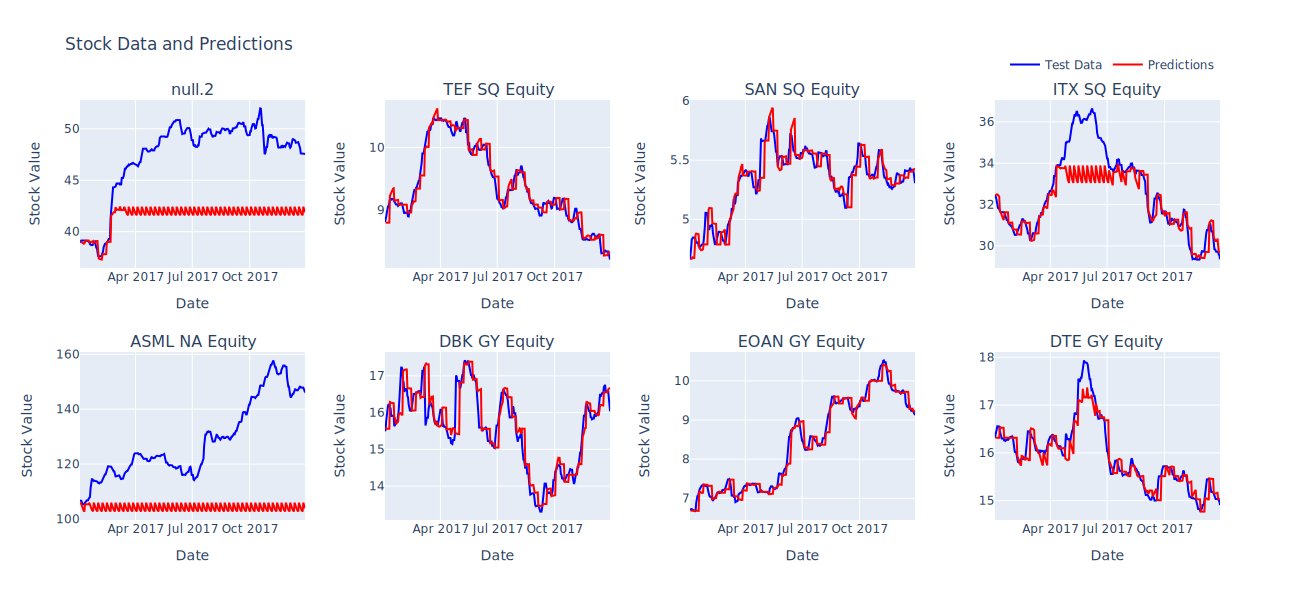

In [99]:
stocks_to_plot = np.random.choice(np.arange(41), size=8, replace=False)

num_rows = 2
num_cols = 4

line_color = ['blue', 'red']

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[data_test.iloc[:, stock].name for stock in stocks_to_plot], horizontal_spacing=0.07, vertical_spacing=0.2)

for i, stock in enumerate(stocks_to_plot):
    row = i // num_cols + 1
    col = i % num_cols + 1

    if i==0:
        fig.add_trace(go.Scatter(x=data_test.index, y=data_test.iloc[:, stock], mode='lines', name='Test Data', line=dict(color=line_color[0])), row=row, col=col)
        fig.add_trace(go.Scatter(x=predictions_ms.index, y=predictions_ms.iloc[:, stock], mode='lines', name='Predictions', line=dict(color=line_color[1])), row=row, col=col)

        fig.update_yaxes(title_text='Stock Value', row=row, col=col)
        fig.update_xaxes(title_text='Date', row=row, col=col)
    else:
        fig.add_trace(go.Scatter(x=data_test.index, y=data_test.iloc[:, stock], mode='lines', name='Test Data', line=dict(color=line_color[0]), showlegend=False), row=row, col=col)
        fig.add_trace(go.Scatter(x=predictions_ms.index, y=predictions_ms.iloc[:, stock], mode='lines', name='Predictions', line=dict(color=line_color[1]), showlegend=False), row=row, col=col)

        fig.update_yaxes(title_text='Stock Value', row=row, col=col)
        fig.update_xaxes(title_text='Date', row=row, col=col)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Stock Value',
    title_text='Stock Data and Predictions',
    showlegend=True,
    width=1300,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1)
)

fig.show(renderer='svg')

## Portfolio creation, optimization and comparison (Multiseries): 

- Ranking the predictions
- Selecting stocks
- Calculate performance of portfolios for different N selections
- Plot the portfolios
- Compare with index

In [100]:
ranking_LGBM = get_ranking(predictions_ms, N = [5, 7, 10], prices=True)
 
perf_LGBM, portfolios_ret_LGBM = calc_portfolios(ranking_LGBM, stocks_returns.loc[predictions_ms.index[0]:])

perf_LGBM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_LGBM

{'Top 5 total performance': 23.624616429910894,
 'Top 7 total performance': 20.86789484181548,
 'Top 10 total performance': 18.21756933924199,
 'Index total performance': 8.73696808872011}

Performance for LigthGBM remain pretty much constant even with different lags. Since this is a Machine Learning model and not a Deep Learning one in which we have to initialize weights and biases), the stocks that are chosen for the portfolios to optimize are basically always the same.

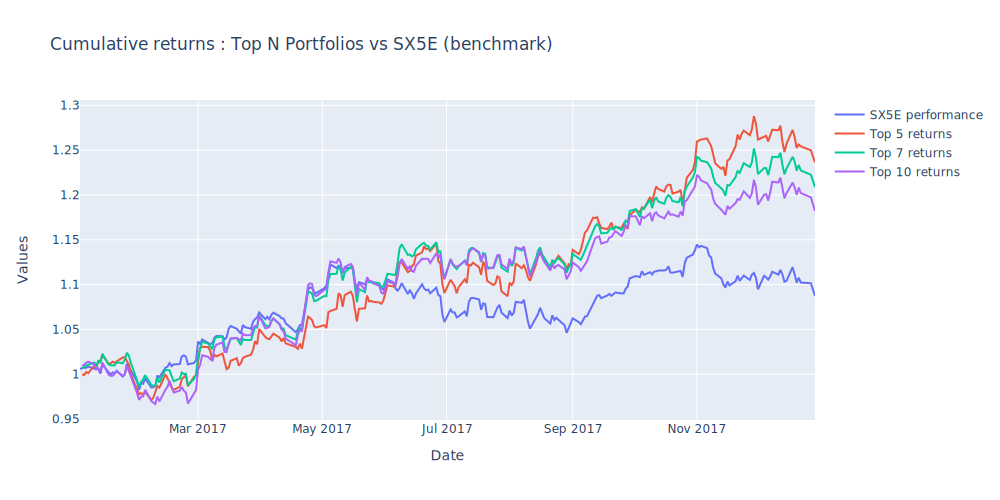

In [101]:
plot_portfolios(portfolios_ret_LGBM, test_index_ret, renderer=True)

In [102]:
report = qs.reports.metrics(portfolios_ret_LGBM['Top 5 returns'],
                benchmark = test_index_ret,
                title = 'LSTM: Top5 vs Benchmark',
                mode = "basic",
                prepare_returns = False)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2017-01-03   2017-01-03
End Period          2017-12-29   2017-12-29
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   8.01%        23.62%
CAGR﹪              5.54%        16.0%

Sharpe              0.82         1.82
Prob. Sharpe Ratio  79.93%       96.88%
Sortino             1.31         3.01
Sortino/√2          0.92         2.13
Omega               1.35         1.35

Max Drawdown        -6.79%       -5.13%
Longest DD Days     171          71

Gain/Pain Ratio     0.15         0.35
Gain/Pain (1M)      0.76         3.75

Payoff Ratio        1.09         1.26
Profit Factor       1.15         1.35
Common Sense Ratio  1.41         1.89
CPC Index           0.64         0.88
Tail Ratio          1.23         1.4
Outlier Win Ratio   3.4          2.57
Outlier Loss Ratio  3.21         2.76

MTD                 -1.8%        -3.36%
3M             

### No backtesting results - good baseline

In [103]:
forecaster_ms.fit(data_train)

In [104]:
preds = forecaster_ms.predict(steps=21)

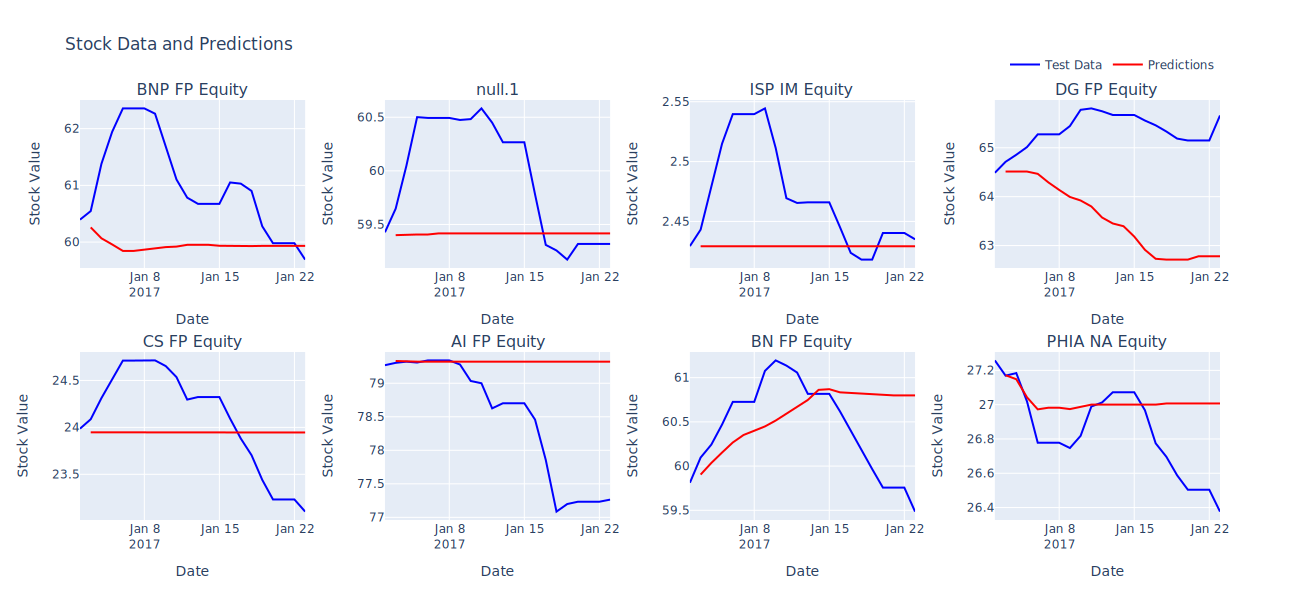

In [105]:
stocks_to_plot = np.random.choice(np.arange(41), size=8, replace=False)

num_rows = 2
num_cols = 4

line_color = ['blue', 'red']

fig = make_subplots(rows=num_rows, cols=num_cols, subplot_titles=[data_test[:22].iloc[:, stock].name for stock in stocks_to_plot], horizontal_spacing=0.07, vertical_spacing=0.2)

for i, stock in enumerate(stocks_to_plot):
    row = i // num_cols + 1
    col = i % num_cols + 1

    if i == 0:
        fig.add_trace(go.Scatter(x=data_test[:22].index, y=data_test.iloc[:, stock], mode='lines', name='Test Data', line=dict(color=line_color[0])), row=row, col=col)
        fig.add_trace(go.Scatter(x=preds.index, y=preds.iloc[:, stock], mode='lines', name='Predictions', line=dict(color=line_color[1])), row=row, col=col)

        fig.update_yaxes(title_text='Stock Value', row=row, col=col)
        fig.update_xaxes(title_text='Date', row=row, col=col)
    else:
        fig.add_trace(go.Scatter(x=data_test[:22].index, y=data_test.iloc[:, stock], mode='lines', name='Test Data', line=dict(color=line_color[0]), showlegend=False), row=row, col=col)
        fig.add_trace(go.Scatter(x=preds.index, y=preds.iloc[:, stock], mode='lines', name='Predictions', line=dict(color=line_color[1]), showlegend=False), row=row, col=col)

        fig.update_yaxes(title_text='Stock Value', row=row, col=col)
        fig.update_xaxes(title_text='Date', row=row, col=col)

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Stock Value',
    title_text='Stock Data and Predictions',
    showlegend=True,
    width=1300,
    height=600,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=1)
)

fig.show(renderer='svg')

In [106]:
ranking_LGBM = get_ranking(preds, N = [5, 7, 10], prices=True)
 
perf_LGBM, portfolios_ret_LGBM = calc_portfolios(ranking_LGBM, stocks_returns.loc[preds.index[0]:])

perf_LGBM['Index total performance'] = ((1 + test_index_ret).prod() - 1) * 100
perf_LGBM

{'Top 5 total performance': 1.874600361948442,
 'Top 7 total performance': 2.029025134718565,
 'Top 10 total performance': 5.947697144860675,
 'Index total performance': 8.73696808872011}

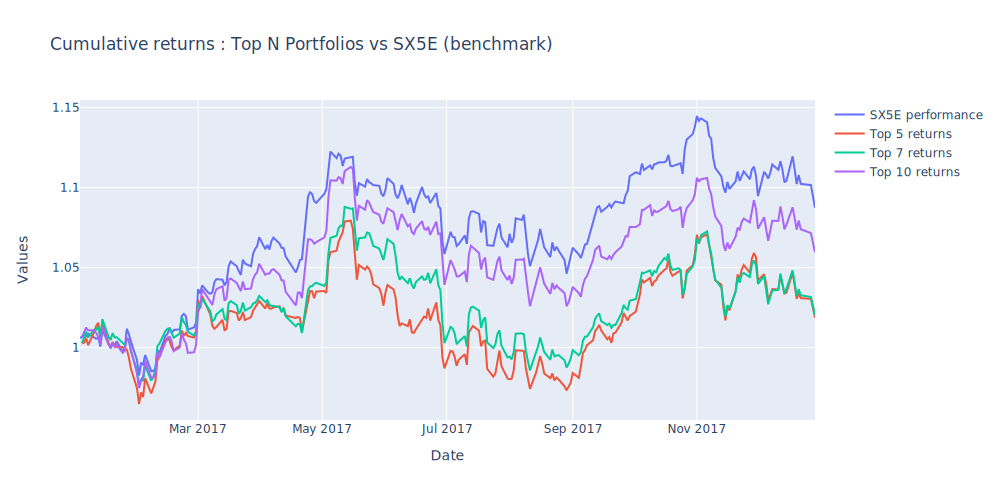

In [107]:
plot_portfolios(portfolios_ret_LGBM, test_index_ret, renderer=True)